In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('files/bandeira_brasil.jpeg', 0)

In [3]:
img.shape

(343, 491)

# Mascaras

In [4]:
# filtro da média
mean_filter = np.ones((3,3)) / 9.

# filtro gaussiano
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# diferentes filtros de detecçao de bordas
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y = np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian = np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

In [5]:
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

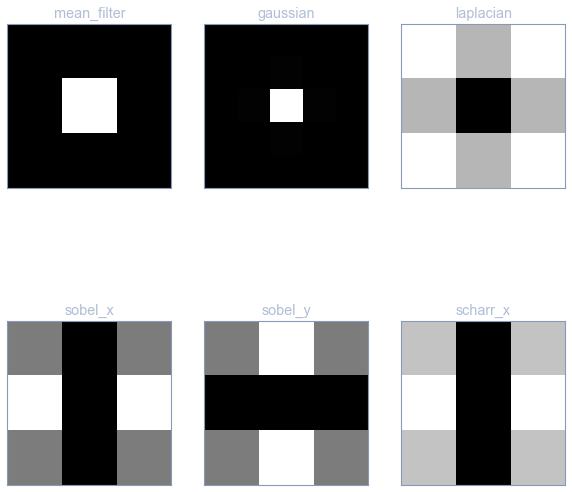

In [6]:
plt.figure(figsize=(10,10))

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()

In [7]:
mask = laplacian

# Convolução

In [8]:
%time
img_conv = cv2.filter2D(img, -1, mask)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


# FFT

In [9]:
#dimensoes
l = img.shape[0]
c = img.shape[1]

In [10]:
%time
# fft usando opencv e shift com numpy
# Com o metodo cv2.dft(...) o resultado e um array com dois canais, 
# sendo um array para o eixo real e outro para o imaginario
# A imagem precisa ser float
img_fft = np.fft.fftshift((cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT)))

# mascara redimensionada (valores movidos para o centro)
filter_mask = np.zeros((l,c))
filter_mask[(l//2)-1:int(np.ceil(l/2))+1,(c//2)-1:int(np.ceil(c/2))+1] = mask

# mascara no dominio da frequencia (fft e shift)
fft_mask = np.fft.fftshift(cv2.dft(np.float32(filter_mask), flags = cv2.DFT_COMPLEX_OUTPUT))
mask_abs = cv2.magnitude(fft_mask[:,:,0],fft_mask[:,:,1])

# replica a magnitude da mascara para os dois canais
fft_mask[:,:,0] = mask_abs
fft_mask[:,:,1] = mask_abs

# filtra no dominio da frequencia
fft_filtered = cv2.multiply(img_fft, fft_mask)

# inverte a FFT
img_back = cv2.idft(np.fft.ifftshift(fft_filtered))
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


# Exibindo os resultados

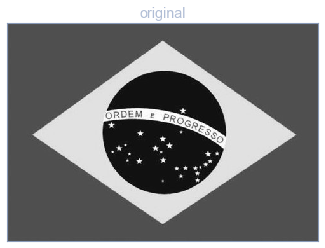

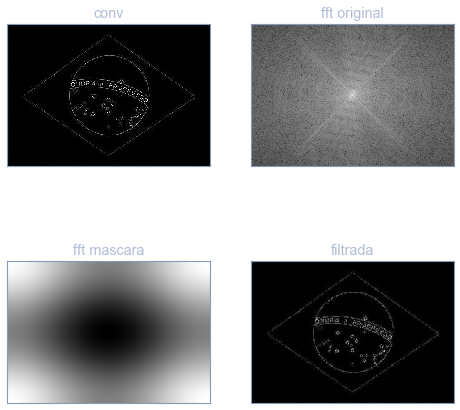

In [11]:
#image plot
imagens = [img_conv,
           np.log(cv2.magnitude(img_fft[:,:,0],img_fft[:,:,1])),
           mask_abs,
           img_back]

plt.title('original')
plt.imshow(img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

titles = ['conv','fft original','fft mascara','filtrada']

plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(imagens[i],cmap = 'gray')
    plt.title(titles[i]), plt.xticks([]), plt.yticks([])

plt.show()        

In [12]:
img_conv, img_back

(array([[ 0, 14,  0, ...,  0,  0,  0],
        [ 0, 14,  0, ...,  0,  0,  0],
        [ 0, 14,  0, ...,  0,  0,  0],
        ...,
        [ 0,  7,  0, ...,  0,  0,  0],
        [ 0,  7,  0, ...,  0,  0,  0],
        [ 0, 22,  0, ...,  4,  4,  4]], dtype=uint8),
 array([[2.3577805e+06, 1.8525462e+06, 2.5261935e+06, ..., 1.6841081e+05,
         1.6841075e+05, 3.3682875e+05],
        [1.6841352e+06, 2.3577762e+06, 1.8525480e+06, ..., 2.8762631e+00,
         2.7453861e+00, 5.0523566e+05],
        [1.6841270e+06, 2.3577860e+06, 1.8525380e+06, ..., 3.6148434e+00,
         3.9879398e+00, 5.0524406e+05],
        ...,
        [3.1998548e+06, 1.1788940e+06, 1.0104759e+06, ..., 3.3683209e+05,
         3.3682600e+05, 6.7365394e+05],
        [2.5261925e+06, 1.1788995e+06, 1.3473010e+06, ..., 3.3681644e+05,
         3.3682088e+05, 3.3683450e+05],
        [6.7365281e+05, 3.3682600e+06, 1.6841581e+05, ..., 5.0523762e+05,
         5.0524144e+05, 5.0524066e+05]], dtype=float32))

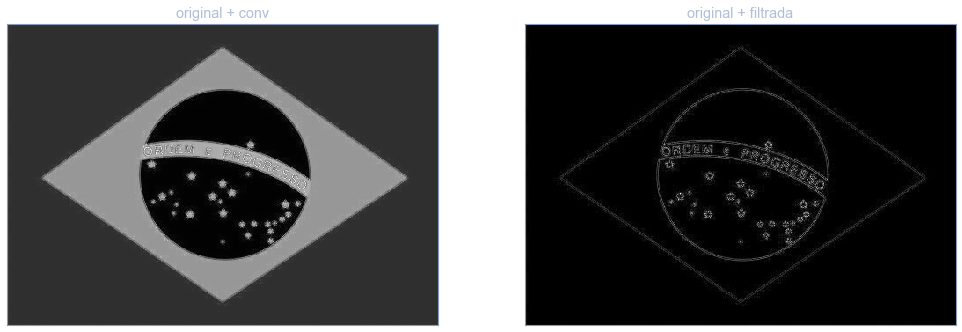

In [13]:
plt.figure(figsize=(17,17))
plt.subplot(1,2,1), plt.imshow(cv2.add(img.astype('float32'), img_conv.astype('float32')), cmap='gray')
plt.title('original + conv'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(cv2.add(img.astype('float32'), img_back.astype('float32')), cmap='gray')
plt.title('original + filtrada'), plt.xticks([]), plt.yticks([])
plt.show()